##  Data Preprocessing with Chunk Processing and Aggregation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import dask.dataframe as dd

In [2]:
# Load dataset in chunks
chunk_size = 500000
consumptions_chunks = pd.read_csv('household_power_consumption.csv',
                        parse_dates={'datetime': ['Date', 'Time']},
                        dayfirst=True,  # Specify dayfirst=True
                        low_memory=False, na_values=['nan','?'], chunksize=chunk_size)

In [3]:
# Process chunks
chunks = []
for chunk in consumptions_chunks:
    chunk = chunk.astype({'Global_active_power': 'float32', 'Global_reactive_power': 'float32', 
                          'Voltage': 'float32', 'Global_intensity': 'float32', 'Sub_metering_1': 'float32', 
                          'Sub_metering_2': 'float32', 'Sub_metering_3': 'float32'})
    chunk = chunk.fillna(chunk.mean())
    chunks.append(chunk)
    
electricity_consumptions = pd.concat(chunks)

In [4]:
# Resample data to daily
electricity_consumptions.set_index('datetime', inplace=True)
electricity_consumptions= electricity_consumptions.resample('D').mean()

# Display the cleaned data
print(electricity_consumptions.head())

            Global_active_power  Global_reactive_power     Voltage  \
datetime                                                             
2006-12-16             3.053475               0.088187  236.243759   
2006-12-17             2.354486               0.156949  240.087021   
2006-12-18             1.530435               0.112356  241.231689   
2006-12-19             1.157079               0.104821  241.999298   
2006-12-20             1.545658               0.111804  242.308075   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
datetime                                                                      
2006-12-16         13.082828        0.000000        1.378788       12.439394  
2006-12-17          9.999027        1.411806        2.907639        9.264584  
2006-12-18          6.421667        0.738194        1.820139        9.734722  
2006-12-19          4.926389        0.582639        5.279167        4.303472  
2006-12-20          6.467361       

##  Exploratory Data Analysis (EDA)

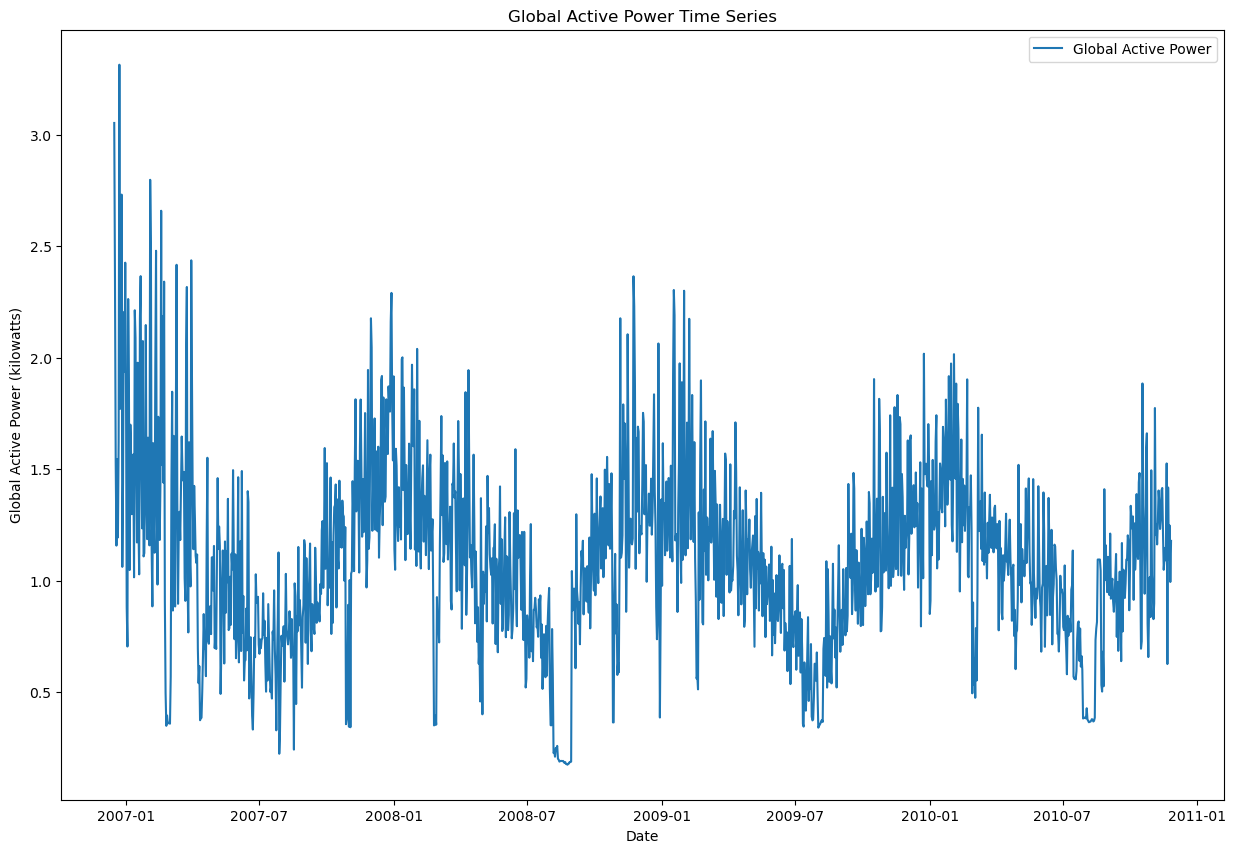

In [5]:
# Plotting the time series data
plt.figure(figsize=(15,10))
plt.plot(electricity_consumptions['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Time Series')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

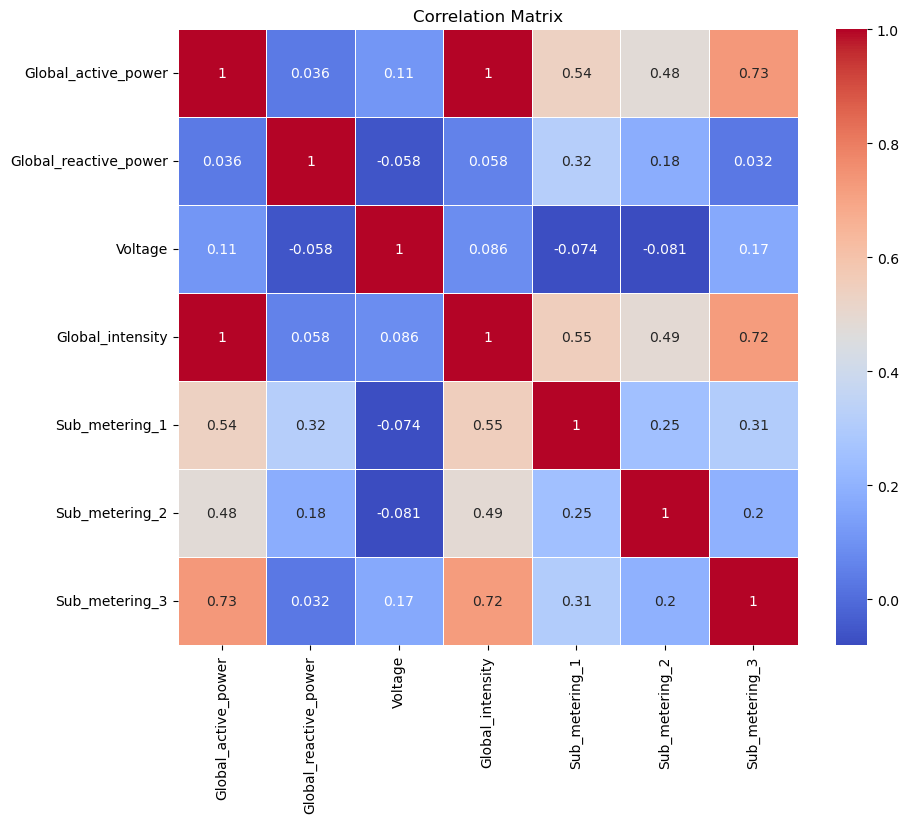

In [6]:
# Plotting correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(electricity_consumptions.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

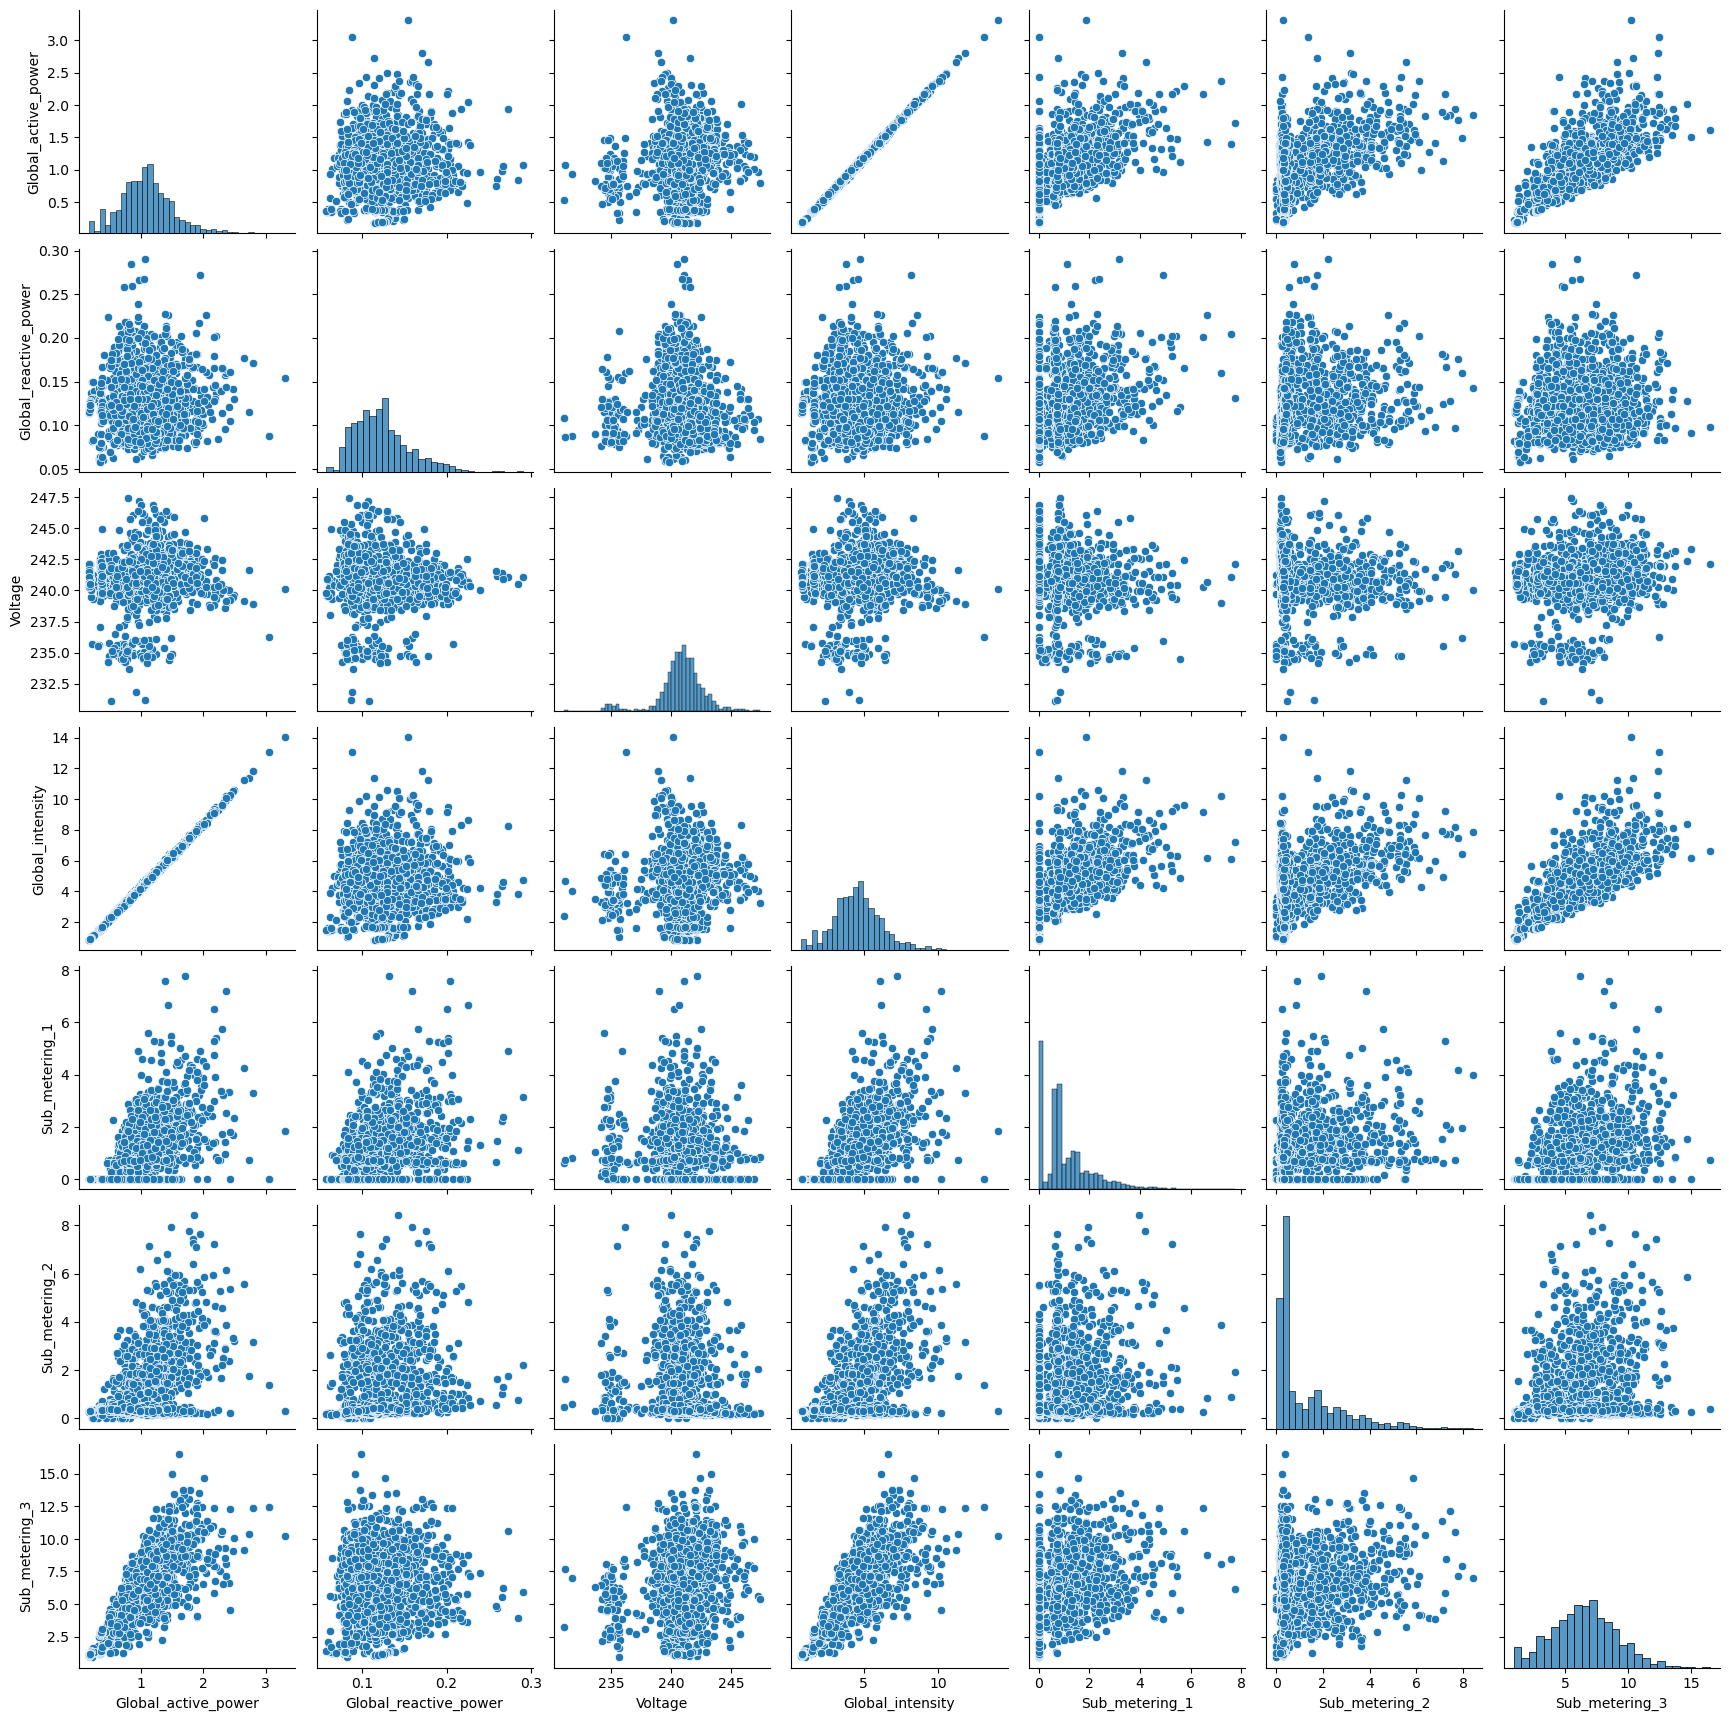

In [7]:
import warnings
warnings.filterwarnings("ignore", message=".*The figure layout has changed to tight.*")

# Visualizing relationships between features
sns.pairplot(electricity_consumptions)
plt.show()

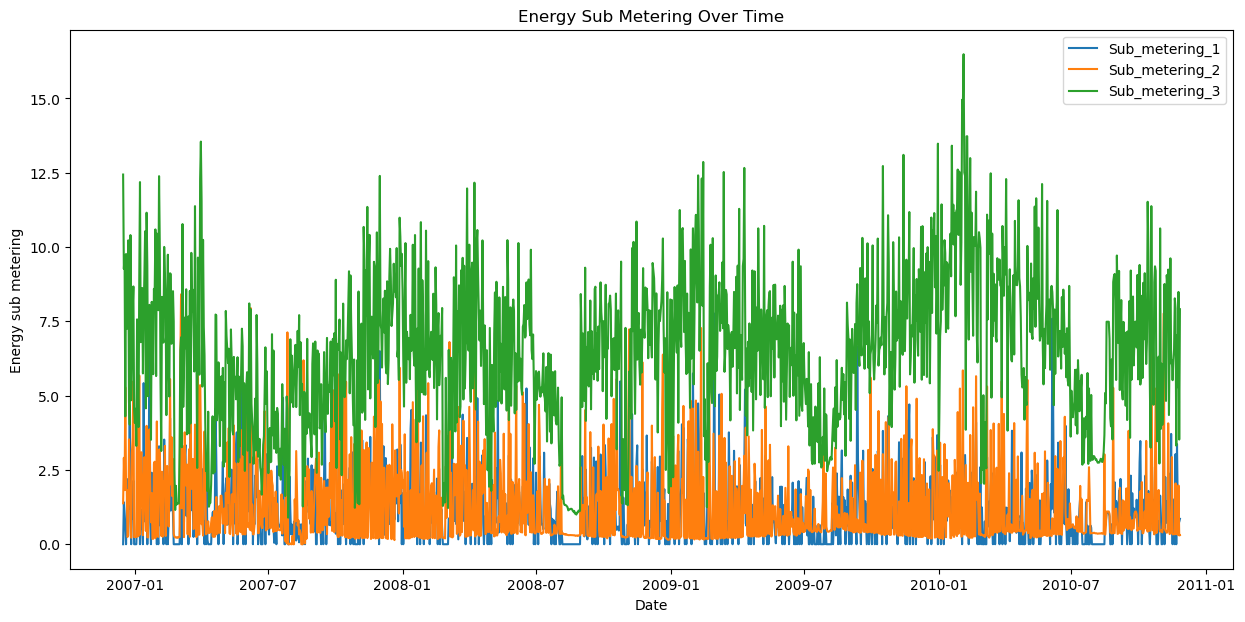

In [8]:
# Plotting sub-metering data
plt.figure(figsize=(15, 7))
plt.plot(electricity_consumptions['Sub_metering_1'], label='Sub_metering_1')
plt.plot(electricity_consumptions['Sub_metering_2'], label='Sub_metering_2')
plt.plot(electricity_consumptions['Sub_metering_3'], label='Sub_metering_3')
plt.xlabel('Date')
plt.ylabel('Energy sub metering')
plt.title('Energy Sub Metering Over Time')
plt.legend()
plt.show()

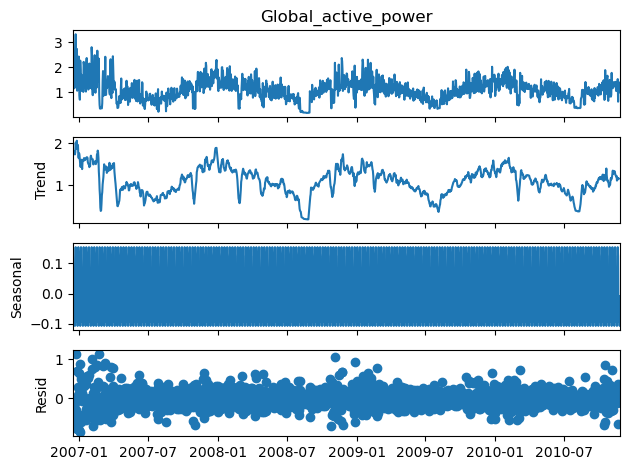

In [9]:
# Checking for seasonality and trends
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(electricity_consumptions['Global_active_power'], model='additive')
fig = decomposition.plot()
plt.show()

##  Time Series Forecasting Models

In [10]:
# ARIMA Model
arima_model = ARIMA(electricity_consumptions['Global_active_power'], order=(5,1,0))
arima_result = arima_model.fit()
print(arima_result.summary())

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1442
Model:                  ARIMA(5, 1, 0)   Log Likelihood                -326.858
Date:                 Tue, 02 Jul 2024   AIC                            665.717
Time:                         14:57:32   BIC                            697.355
Sample:                     12-16-2006   HQIC                           677.527
                          - 11-26-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5618      0.020    -28.153      0.000      -0.601      -0.523
ar.L2         -0.5656      0.023    -24.777      0.000      -0.610      -0.521
ar.L3         -0.3494      0.025    -13.952 

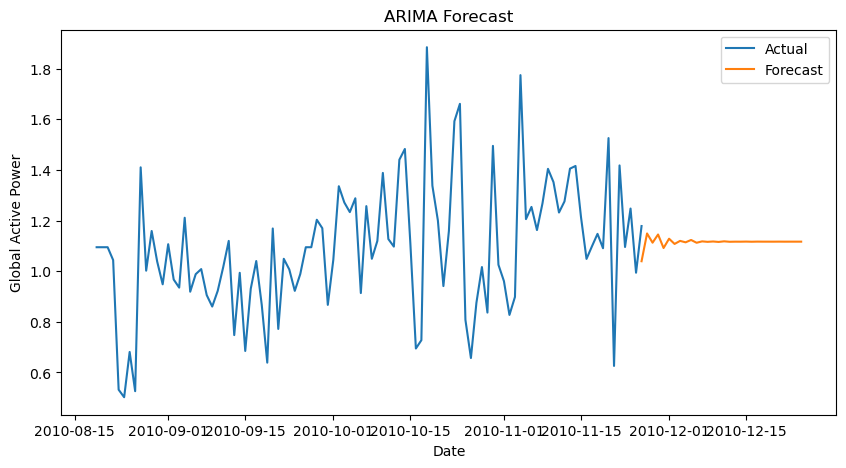

In [11]:
# Forecasting with ARIMA
arima_forecast = arima_result.forecast(steps=30)
plt.figure(figsize=(10,5))
plt.plot(electricity_consumptions.index[-100:], electricity_consumptions['Global_active_power'].values[-100:], label='Actual')
plt.plot(pd.date_range(electricity_consumptions.index[-1], periods=30, freq='D'), arima_forecast, label='Forecast')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

In [12]:
# SARIMA Model
sarima_model = SARIMAX(electricity_consumptions['Global_active_power'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                 1442
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -354.005
Date:                            Tue, 02 Jul 2024   AIC                            718.010
Time:                                    14:57:36   BIC                            744.334
Sample:                                12-16-2006   HQIC                           727.840
                                     - 11-26-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2228      0.026      8.685      0.000       0.173       0.273
ma.L1         -0.8699      0.015   

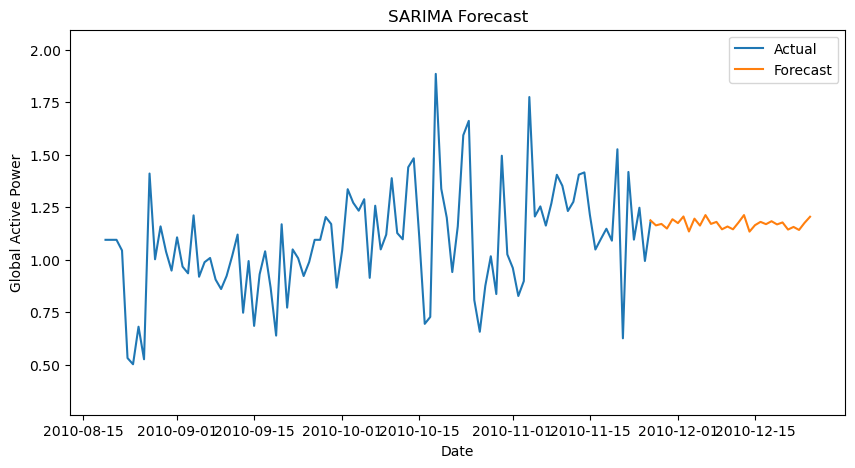

In [13]:
# Forecasting with SARIMA
sarima_forecast = sarima_result.get_forecast(steps=30)
sarima_conf_int = sarima_forecast.conf_int()
plt.figure(figsize=(10,5))
plt.plot(electricity_consumptions.index[-100:], electricity_consumptions['Global_active_power'].values[-100:], label='Actual')
plt.plot(pd.date_range(electricity_consumptions.index[-1], periods=30, freq='D'), sarima_forecast.predicted_mean, label='Forecast')
plt.fill_between(pd.date_range(electricity_consumptions.index[-1], periods=30, freq='D'), sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='white', alpha=0.1)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

In [14]:
# Prepare data for LSTM
from sklearn.preprocessing import MinMaxScaler

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


In [15]:
# Reshape and split the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(electricity_consumptions['Global_active_power'].values.reshape(-1, 1))

look_back = 10
X, Y = create_dataset(dataset, look_back)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [16]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, Y_train, batch_size=1, epochs=1)

1144/1144 [==============================] - 7s 2ms/step - loss: 0.0105


In [17]:
# Forecasting with LSTM
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

9/9 [==============================] - 1s 2ms/step


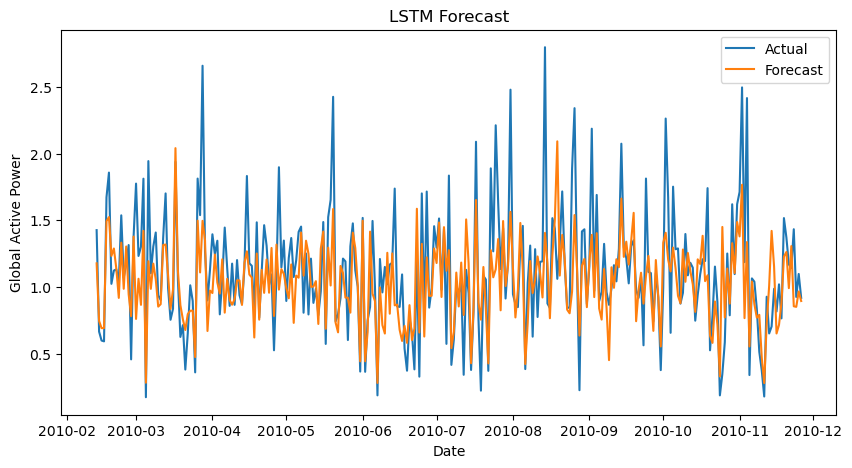

In [18]:
# Plotting LSTM results
plt.figure(figsize=(10,5))
plt.plot(electricity_consumptions.index[-len(Y_test):], scaler.inverse_transform(Y_test.reshape(-1, 1)), label='Actual')
plt.plot(electricity_consumptions.index[-len(Y_test):], lstm_predictions, label='Forecast')
plt.title('LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

## Feature Engineering

In [19]:
# Create additional features
electricity_consumptions['Year'] = electricity_consumptions.index.year
electricity_consumptions['Month'] = electricity_consumptions.index.month
electricity_consumptions['Day'] = electricity_consumptions.index.day
electricity_consumptions['DayOfWeek'] = electricity_consumptions.index.dayofweek
electricity_consumptions['IsWeekend'] = electricity_consumptions['DayOfWeek'].apply(lambda x: 1 if x > 4 else 0)

In [20]:
# Display the enhanced dataset
electricity_consumptions.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Month,Day,DayOfWeek,IsWeekend
datetime,,,,,,,,,,,,
2006-12-16,3.053475,0.088187,236.243759,13.082828,0.000000,1.378788,12.439394,2006,12,16,5,1
2006-12-17,2.354486,0.156949,240.087021,9.999027,1.411806,2.907639,9.264584,2006,12,17,6,1
2006-12-18,1.530435,0.112356,241.231689,6.421667,0.738194,1.820139,9.734722,2006,12,18,0,0
2006-12-19,1.157079,0.104821,241.999298,4.926389,0.582639,5.279167,4.303472,2006,12,19,1,0
2006-12-20,1.545658,0.111804,242.308075,6.467361,0.000000,1.838889,9.765972,2006,12,20,2,0


In [21]:
# Create lag features
for lag in range(1, 8):
   electricity_consumptions[f'lag_{lag}'] = electricity_consumptions['Global_active_power'].shift(lag)

# Create rolling mean features
electricity_consumptions['rolling_mean_3'] = electricity_consumptions['Global_active_power'].rolling(window=3).mean()
electricity_consumptions['rolling_mean_7'] = electricity_consumptions['Global_active_power'].rolling(window=7).mean()

# Drop missing values created by lag features
electricity_consumptions.dropna(inplace=True)

In [22]:
electricity_consumptions

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Month,Day,...,IsWeekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean_3,rolling_mean_7
datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-23,3.314852,0.153799,240.136063,14.028056,1.853472,0.295139,10.226389,2006,12,23,...,1,1.625929,1.193634,1.545658,1.157079,1.530435,2.354486,3.053475,2.044805,1.817439
2006-12-24,1.770842,0.104097,241.687439,7.640417,1.182639,3.529167,4.785417,2006,12,24,...,1,3.314852,1.625929,1.193634,1.545658,1.157079,1.530435,2.354486,2.237207,1.734061
2006-12-25,1.904945,0.166861,243.399933,7.951528,4.597222,1.362500,4.024305,2006,12,25,...,0,1.770842,3.314852,1.625929,1.193634,1.545658,1.157079,1.530435,2.330213,1.787563
2006-12-26,2.732021,0.114654,241.625427,11.347917,0.754167,1.759028,10.402083,2006,12,26,...,0,1.904945,1.770842,3.314852,1.625929,1.193634,1.545658,1.157079,2.135936,2.012554
2006-12-27,1.061639,0.124238,243.767365,4.517500,0.000000,0.218056,4.844444,2006,12,27,...,0,2.732021,1.904945,1.770842,3.314852,1.625929,1.193634,1.545658,1.899535,1.943409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-22,1.417733,0.098857,240.197113,6.014167,3.371528,1.465278,7.038889,2010,11,22,...,0,0.625632,1.525699,1.090556,1.147328,1.098633,1.048436,1.213460,1.189688,1.136288
2010-11-23,1.095511,0.095451,240.575516,4.674445,1.299306,0.318056,5.285417,2010,11,23,...,0,1.417733,0.625632,1.525699,1.090556,1.147328,1.098633,1.048436,1.046292,1.143013
2010-11-24,1.247394,0.091986,240.030975,5.249583,0.761111,1.977778,8.488889,2010,11,24,...,0,1.095511,1.417733,0.625632,1.525699,1.090556,1.147328,1.098633,1.253546,1.164265


## Model Evaluation and Tuning

In [23]:
from sklearn.metrics import mean_squared_error

# Evaluate ARIMA
arima_mse = mean_squared_error(electricity_consumptions['Global_active_power'][-30:], arima_forecast)
print('ARIMA MSE:', arima_mse)

# Evaluate SARIMA
sarima_mse = mean_squared_error(electricity_consumptions['Global_active_power'][-30:], sarima_forecast.predicted_mean)
print('SARIMA MSE:', sarima_mse)

# Evaluate LSTM
lstm_mse = mean_squared_error(Y_test, lstm_predictions)
print('LSTM MSE:', lstm_mse)

ARIMA MSE: 0.05968166455556217
SARIMA MSE: 0.058554626841327756
LSTM MSE: 0.58669436


In [24]:
# Select the best model based on MSE
best_model = min((arima_mse, 'ARIMA'), (sarima_mse, 'SARIMA'), (lstm_mse, 'LSTM'))
print(f'The best model is {best_model[1]} with MSE: {best_model[0]}')

The best model is SARIMA with MSE: 0.058554626841327756


## Future Consumption Prediction

In [25]:
if best_model[1] == 'ARIMA':
    forecast = arima_result.forecast(steps=90)
elif best_model[1] == 'SARIMA':
    forecast = sarima_result.get_forecast(steps=90).predicted_mean
else:
    forecast = lstm_model.predict(X_test[-90:])
    forecast = scaler.inverse_transform(forecast)

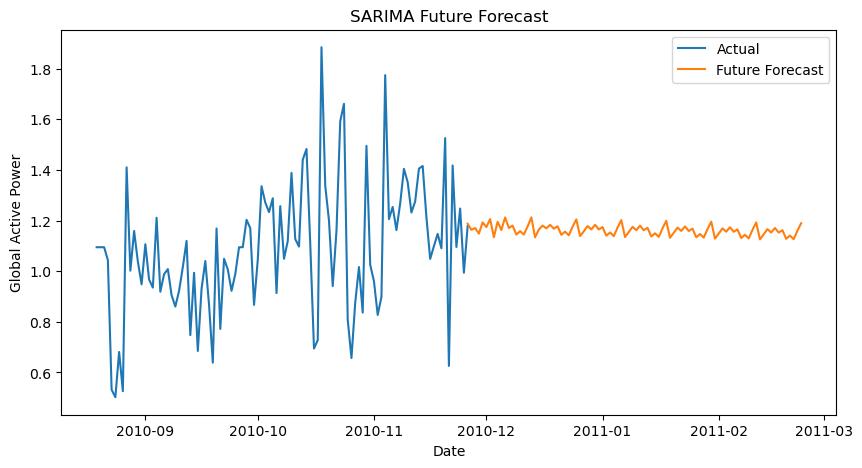

In [26]:
# Plot the future predictions
plt.figure(figsize=(10,5))
plt.plot(electricity_consumptions.index[-100:], electricity_consumptions['Global_active_power'].values[-100:], label='Actual')
plt.plot(pd.date_range(electricity_consumptions.index[-1], periods=90, freq='D'), forecast, label='Future Forecast')
plt.title(f'{best_model[1]} Future Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

In [27]:
# Assuming lstm_model is already trained and ready for predictions
forecast = lstm_model.predict(X_test[-90:])
forecast = scaler.inverse_transform(forecast)  # Inverse transform to original scale if needed

3/3 [==============================] - 0s 5ms/step


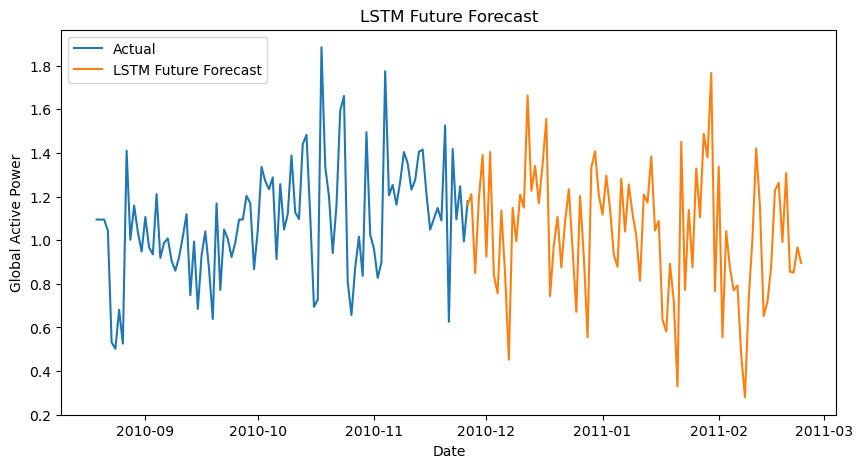

In [28]:
# Plot the future predictions
plt.figure(figsize=(10, 5))
plt.plot(electricity_consumptions.index[-100:], electricity_consumptions['Global_active_power'].values[-100:], label='Actual')
plt.plot(pd.date_range(electricity_consumptions.index[-1], periods=90, freq='D'), forecast, label='LSTM Future Forecast')
plt.title('LSTM Future Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()